In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics as stats
# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

from scipy.integrate import quad, cumtrapz
from scipy.interpolate import interp1d

In [8]:
from constants_module import alpha, c, hbar_GeV, me, k, h
import Compton as comp

***
# More accurate electron differential number density
***

In [9]:
#d_cyg_ref = 1.5e+3           # reference distance of the Cygnus-X region, in [pc]
conv_pc_cm = 3.086e+18       # conversion factor from [pc] to [cm]
conv_cm_pc = 3.24e-19        # conversion factor from [cm] to [pc]
conv_s_yr = 3.171e-8         # conversion factor from [sec] to [yr]
conv_yr_sec = 3.154e+7       # conversion factor from [yr] to [sec]
conv_rad_degree = 57.2958    # conversion factor from [rad] to [deg]
c = 2.998e+10                # speed of light, in [cm/s]

## Source Term

In [10]:
def Q_injected(Ee, Qnorm):
    ''' 
    Describes the source term for the transport equation describing the 
    electron motion throughout the TeV halo. 
    
    - perams - 
    Ee: electron energy (GeV)
    Qnorm: normalization factor for the power law

    - returns -
    injected electron power law spectrum
    '''
    alpha = 1.5 # default from hooper
    Ecut = 5e5 # GeV - exponential decay starts around here

    return Qnorm*Ee**(-alpha) * np.exp(-Ee / Ecut)

In [11]:
def L(t, L0):
    ''' 
    Describes time dependence of the injected electron spectrum.

    - perams -
    t: time
    L0: luminosity of electron positron pairs as a ratio of spin down
    power from the pulsar

    - returns -
    time dependent luminosity of the halo
    
    '''
    tau = 12 # kyr - characteristic spin down timscale
    n = 3 # unitless - magnetic dipole breaking

    expon = -(n+1)/(n-1)

    return L0*(1 + t/tau)**expon

In [12]:
def Q(Ee, r, t, Qnorm):
    ''' 
    Describes the entire injected electron spectrum. 

    - perams - 
    Ee: electron energy (GeV)
    r: radius from center of halo?
    t: time (s)
    Qnorm: normalization factor on injected spetrum
    
    - returns - 
    injected spectrum with time and positional dependence
    '''
    # eta is the percentage of spin down power that goes into producing
    # electron positron pairs above 0.1 GeV
    eta = 1 
    L0 = eta # *total_spin_down_power

    Q_injected(Ee, Qnorm)*L(t, L0)# * dirac_delta_function(r)

## Energy loss rates

In [13]:
def b_sync(Ee):
    ''' 
    Energy losses due to synchrotron radiation.

    - perams - 
    Ee: electron energy (GeV)

    - returns - 
    energy loss due to synchrotron radiation
    '''
    sig_T = comp.rest_sig_T() # cm^2
    B = 3e-6 # Gauss

    u_B = 0.22*(1e-9) # eV/cm

    #u_B = B**2 / (8 * np.pi)  # energy density of magnetic field in Gauss^2
    b_syn = (4/3) * sig_T * c * u_B * (Ee / me)**2
    
    return b_syn

def Si(Ee, Ti):
    ''' 
    Defines the suppression factor in the KN regime. 
    Approximate result from arXiv:2010.13825. 
    '''
    # boltzman constant in GeV
    k_GeV = 8.617*10**(-14)

    Ai = (45 * me**2)/(64 * (np.pi**2) * k_GeV * Ti**2)

    return Ai/(Ai + (Ee/me)**2)

def b_ics_i(Ee, ui, T):
    '''
    Inverse comton energy losses.

    - perams - 
    Ee: Electron energy
    ui: energy density
    T: temperature of blackbody

    - returns -
    losses due to inverse compton scattering in given regime
    '''

    sig_T = comp.rest_sig_T() # cm^2

    top = 4*sig_T*ui*Si(Ee, T) * c # --> Likely right but I am not sure
    bot = 3 # *(c**3) # --> USURE ABOUT THIS, couldn't find it in other sources

    return (top/bot)*(Ee/me)**2

def b_tot(Ee):
    ''' 
    Combines all ICS component losses:
        CMB: u = 0.26 eV/cm^3, T = 2.75 K
        IR: u = 0.60 eV/cm^3, T = 20 K
        Starlight: u = 0.60 eV/cm^3, T = 5000 K
    '''
    #losses due to cmb photons
    u_cmb = 0.26*(1e-9) # GeV/cm^3
    T_cmb = 2.75 # K
    b_cmb = b_ics_i(Ee, u_cmb, T_cmb)

    # losses due to ir photons
    u_ir = 0.60*(1e-9) # GeV/cm^3
    T_ir = 20 # K
    b_ir = b_ics_i(Ee, u_ir, T_ir)

    # losses due to starlight photons
    u_star = 0.60*(1e-9) # GeV/cm^3
    T_star = 5000 # K
    b_star = b_ics_i(Ee, u_star, T_star)

    # total inverse compton scattering losses
    b_ics =  b_cmb + b_ir + b_star

    #losses from synchrotron radiation
    b_syn = b_sync(Ee)

    # total energy loss
    b_tot = b_ics + b_syn

    return b_tot #*(1e-12)
    

In [14]:
b_tot(1e-2)

8.439798838739229e-21

In [15]:
# approximate b
def b_approx(Ee):
    '''
    Approximate energy loss rate assuming we don't care too much about
    being off by a factor of 1.5.
    '''
    b0 = 1.4e-16 # 1/(GeV*s)
    return b0*Ee**2

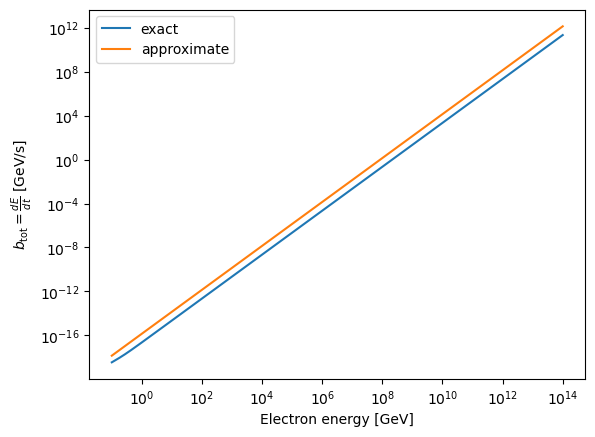

In [16]:
E_test = np.logspace(-1, 14, 1000) # GeV

bs = []

for i in range(len(E_test)):
    bs.append(b_tot(E_test[i]))

plt.loglog(E_test, bs, label = "exact")
plt.loglog(E_test, b_approx(E_test), label = "approximate")
plt.xlabel("Electron energy [GeV]")
plt.ylabel(r"$b_{\text{tot}} = \frac{dE}{dt}$ [GeV/s]")
plt.legend()
plt.show()

## Solving for $E_0$

In [17]:
def E0_approx(Ee, t_diff):
    '''
    Using the approximate energy loss rate, finding the injected energy
    as a function of time.
    '''
    b0 = 1.4e-16
    result = Ee/(1 - b0*(t_diff)*Ee)
    return result

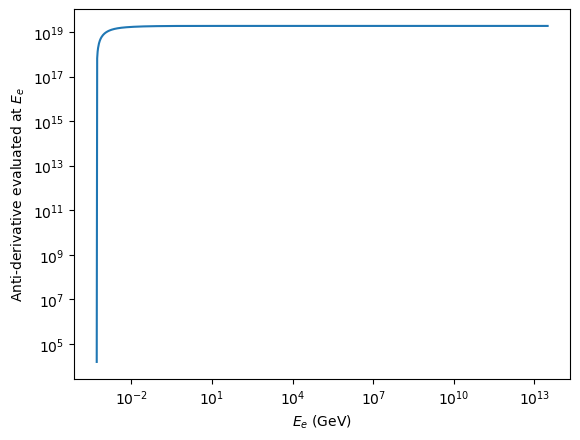

In [18]:
def B_anti_log(Ex, Emin=me):    
    '''
    Computes the antiderivative of 1/btot at a given energy to then later
    solve for E0 (the intial electron energy) as a function of Ee and t.
    Utilizes logspace to get the integral to work out properly.

    - perams - 
    Ex: some electron energy value to evaluate at
    Emin: minimum value for the integral, set to 0.1 GeV ( for now )

    - returns - 
    the antiderivative of 1/btot evaluated at Ex
    '''
    log_Emin = np.log(Emin)
    log_Ex = np.log(Ex)

    def integrand_B_log(log_Ex):
        Ex = np.exp(log_Ex)
        return Ex / b_tot(Ex)
    
    result, error = quad(integrand_B_log, log_Emin, log_Ex,
                        epsabs=1e-12, epsrel=1e-10)
    return result

Emax = np.pi*10**13

E_test = np.logspace(np.log10(me), np.log10(Emax), 1000)
B_antis = [B_anti_log(E) for E in E_test]
plt.loglog(E_test, B_antis)
plt.xlabel(r"$E_e$ (GeV)")
plt.ylabel("Anti-derivative evaluated at $E_e$")
plt.show()

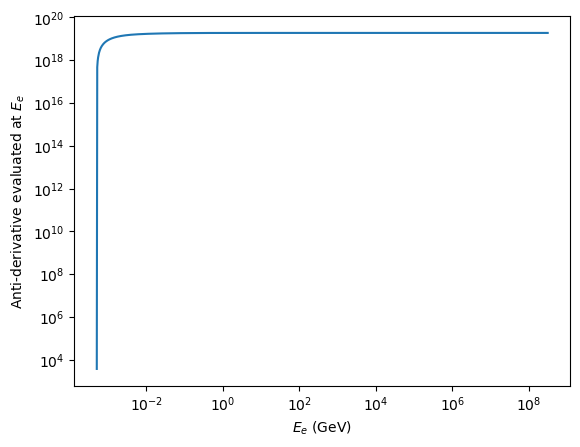

In [19]:
def B_anti(Ex, Emin=me):    
    '''
    Computes the antiderivative of 1/btot at a given energy to then later
    solve for E0 (the intial electron energy) as a function of Ee and t.
    Utilizes logspace to get the integral to work out properly.

    - perams - 
    Ex: some electron energy value to evaluate at
    Emin: minimum value for the integral, set to 0.1 GeV ( for now )

    - returns - 
    the antiderivative of 1/btot evaluated at Ex
    '''
    E_test = np.logspace(np.log10(me), np.log10(Ex), 50)

    def integrand_B(Ex):
        return 1 / b_tot(Ex)
    
    result, error = quad(integrand_B, Emin, Ex, points = E_test, 
                        epsabs=1e-12, epsrel=1e-10, limit = 1000)
    return result

Emax = np.pi*10**8

E_test = np.logspace(np.log10(me), np.log10(Emax), 1000)
B_antis = [B_anti(E) for E in E_test]
plt.loglog(E_test, B_antis)
plt.xlabel(r"$E_e$ (GeV)")
plt.ylabel("Anti-derivative evaluated at $E_e$")
plt.show()

## Inverting the funciton

In [20]:
def spline_to_E0s(Emin = me, Emax = 1e40):
    n_points = 100000

    Es = np.logspace(np.log10(Emin), np.log10(Emax), n_points)

    Bs_at_Es = []
    for i in range(n_points):
        Bs_at_Es.append(B_anti(Es[i]))

    inv_spline = interp1d(Bs_at_Es, Es, bounds_error=False, fill_value='extrapolate')

    return inv_spline

E0_spline = spline_to_E0s()

In [21]:
def E0_val(Ee, tau):
    '''
    Computes the inital photon energy as a function of final
    photon energy and time difference between observation and 
    injection(tstar). Utilizes a inverse function spline to find
    the E0 that solves the necessary equation for a given Ee and
    tau.

    - perams -
    Ee: final photon energy
    tau: tobs - tinj (Defined in the hooper paper)

    - returns - 
    value of E0 at given Ee and tau
    maximum value of Ee for wich the function is defined, above that 
    there isn't any well defined values
    '''
    value = B_anti(Ee) + tau
    return E0_spline(value)

In [22]:
def max_Ee(tau):
    # Finding the maximum value

    # THESE POINTS MAKE A BIG DIFF IN THE MAX ENERGY(not OOM but still)
    points = 500
    Ees = np.logspace(np.log10(1), np.log10(1e6), points)

    vals = []
    for i in range(points):
        vals.append(B_anti(Ees[i]) + tau)

    E0s = E0_spline(vals)

    maxIdx = np.argmax(E0s)

    Ee_max = Ees[maxIdx]

    return Ee_max

max_Ee(7.5e11)

59367.27216069126

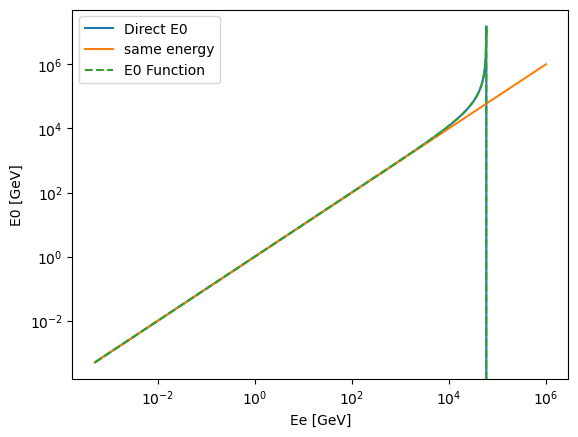

In [23]:
def plot_E0s():
    points = 1000
    Ees = np.logspace(np.log10(me), np.log10(1e6), points)
    tau = 7.5e11

    vals = []
    vals_2 = []
    for i in range(points):
        vals.append(B_anti(Ees[i]) + tau)
        vals_2.append(E0_val(Ees[i], tau))

    plt.loglog(Ees, E0_spline(vals), label = "Direct E0")
    plt.loglog(Ees, Ees, label = "same energy")
    plt.loglog(Ees, vals_2, label = "E0 Function", linestyle = "dashed")
    plt.legend()
    plt.xlabel("Ee [GeV]")
    plt.ylabel("E0 [GeV]")
    plt.show()

plot_E0s()


***
# Diffusion
***

In [24]:
# Two zone model 

def diffusion_hoop(Ee, r):
    ''' 
    Diffusion model from the hooper paper, uses a two zone diffusion model
    with a factor rh that describes where the model changes from one zone
    to the next. Spherical diffusion is required by the results of the 
    Luque et. al. paper. 

    - perams -
    r: distance from center of pulsar halo
    '''
    # rh: radius when the diffusion model 'switches zones, set as 30 pc in hooper
    rh = 30 # parsecs
    if r < rh: 
        # coefficient for r < rh
        D0 = 1e26 # cm^2 / s
        del_exponent = 1/3 # hooper default

        # (Ee/1 GeV) below is just 1 because we are already in GeV
        return D0*(Ee/1)**del_exponent
    elif r >= rh:
        Dism = 4e28 # cm^2 / s
        del_ism = 1/3

        return Dism*(Ee/1)**del_ism
    else:
        print(f'Error in reading in radius for diffusion')
        return 0 
    

def diffusion_len(E0, Ee, r):
    '''
    Uses the diffusion coefficient to find the diffusion length.

    - perams - 
    Ee: final electron energy (GeV)
    E0: intial electron energy (GeV)

    - returns - 
    diffusion length
    '''
    def diffusion_integrand(Ee, r):
        return diffusion_hoop(Ee, r)/b_tot(Ee)
    
    result = quad(diffusion_integrand, E0, Ee, r)[0]

    if result < 0:
        print("INTEGRAND RESULT IS LESS THAN 0")
        print(f"E0 = {E0}, Ee = {Ee}, r = {r}")

    return np.sqrt(4*result)

Ee_test = 100
tau_test = 1e12
diffusion_len(Ee_test, E0_val(Ee_test, tau_test), 10)

4.309852129830868e+19

***
# FULL SPECTRUM --> Using Geminga Numbers
***

## New L0

In [25]:
''' From Leuque '''
#d_cyg_ref = 1.5e+3           # reference distance of the Cygnus-X region, in [pc]
conv_pc_cm = 3.086e+18       # conversion factor from [pc] to [cm]
conv_cm_pc = 3.24e-19        # conversion factor from [cm] to [pc]
conv_s_yr = 3.171e-8         # conversion factor from [sec] to [yr]
conv_yr_sec = 3.154e+7       # conversion factor from [yr] to [sec]
conv_rad_degree = 57.2958    # conversion factor from [rad] to [deg]
c = 2.998e+10                # speed of light, in [cm/s]

## Source term
tau_0 = 1.2e4*conv_yr_sec # 12 kyr -> seconds  #1.2e6*3.1e10 # 1.20 Myr -> seconds    #1.2e4*3.1e10 # 12 kyr -> seconds
Edot = 3.2e34 # erg/s  # Geminga-like. Taken from various references, among them arXiv:2107.07395v1 
L_0 = Edot * 624.151 # L/eta at t = 0 -- erg/s -> GeV/s
Q_0 = 3.2 # d^{2}N/dE^{2} -- particles/GeV^2


In [26]:
def new_L0():
    #W0 = 9.39e49
    W0 = 1e10 # NOT ACTUAL VALUE, JUST A PLACEHOLDER FOR COMPUTATIONAL SPEED

    def igrand(t):
        tau = 12e3
        return 1/(+t/tau)**2

    L_time = quad(igrand, 0, 370e3)[0]

    def igrand2(Ee):
        alpha = 1.5 # default from hooper
        Ecut = 5e5 # GeV - exponential decay starts around here
        return Ee**(-alpha) * np.exp(-Ee / Ecut)
        

    L_gen = quad(igrand2, me, 1e6)[0]

    return W0/(L_time * L_gen)

newL0 = new_L0()


/var/folders/wl/gwbb_1zs7579vsxsrtl309740000gn/T/ipykernel_67707/61159931.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  L_time = quad(igrand, 0, 370e3)[0]
/var/folders/wl/gwbb_1zs7579vsxsrtl309740000gn/T/ipykernel_67707/61159931.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  L_gen = quad(igrand2, me, 1e6)[0]


In [27]:
import scipy as sp

In [ ]:
def H(r, Ee, E0, rs = 1):
    '''
    Defined in Di Mauro et. al. paper
    
    - perams - 
    r: position in galactic coordinates
    '''

    # rs is the source position
    del_r = r - rs

    # diffusion lengths
    l_0 = diffusion_len(Ee, E0, 0)*conv_cm_pc # setting r to 0 pc so it uses D0
    l_ism = diffusion_len(Ee, E0, 100)*conv_cm_pc # setting r to 100 pc so it uses Dism

    # Defining perameters in paper
    D0 = 1e26 # cm^2 / s
    Dism = 4e28 # cm^2 / s

    # rh: radius when the diffusion model 'switches zones, set as 30 pc in hooper
    rh = 30 # parsecs

    xi = np.sqrt(D0/Dism)

    # epsilon definition
    ep = rh/l_0
    erf = sp.special.erf(ep)
    erfc = sp.special.erfc(ep)

    # Implementing the function
    bot00 = (np.pi*(l_0**2))**(3/2)
    bot01 = 2*(xi**2)*erf
    bot02 = xi*(xi-1)*erf
    bot03 = 2*erfc
    term0 = (xi*(xi+1)) / (bot00)*(bot01 - bot02 + bot03) 

    # r dependence
    if r < rh:
        term1 = np.exp( - (del_r**2) / (l_0**2) )
        term21 = (xi-1)/(xi + 1)
        term22 = (2*rh)/(r) - 1
        term23 = np.exp( - ((del_r-2*rh)**2) / (l_0**2) )
        term2 = term21*term22*term23

        result = term0*(term1+term2)

    else:
        term01 = (2*xi)/(xi + 1)
        term02 = np.exp( - (((del_r - rh)/l_ism) + rh/l_0 )**2 )
        term1 = rh/r
        term2 = xi*(1-rh/r)

        result = term0*term01*term02*(term1 + term2)

    return result


### Testing the H solution

In [29]:
def full_Ne_mauro(Ee, r, t, rs = 1):
    '''
    Combines everything from above to make a full electron spectrum 
    from the pulsar halo. 

    - perams -
    Ee: electron energy
    r: position in galactic coordinates
    rs: location of source in galactic coordinates
    t: time (in seconds)

    - returns - 
    value at a specified Electron energy
    '''
    # time --> WRONG CHECK THIS
    tobs = (110e3)*conv_yr_sec #geminga age
    tdiff = tobs - t

    # # calculating Ee max for given t
    # Ee_max = max_Ee(tdiff)

    # # if Ee >= Ee_max:
    # #     return 0
    
    E0 = E0_val(Ee, tdiff)

    if E0 < 0:
        return 0

    b0 = b_tot(E0)
    be = b_tot(Ee)

    term_b = b0/be

    def L_mauro(t, L0, tau0 = 12*conv_yr_sec):
        return L0/( (1 + t/tau0)**2)

    # DIFFERENT FROM IN MAURO
    # eta = 0.25 # Hooper default?
    # L0 = L_0*eta #using value from leuque

    # Mauro calculation
    L0 = newL0
    
    lum = L_mauro(t, L0)

    term_Q = lum*Q_injected(E0, Q_0)

    result = term_b * term_Q * H(r, Ee, E0, rs = 1)

    return result

## Code plots 

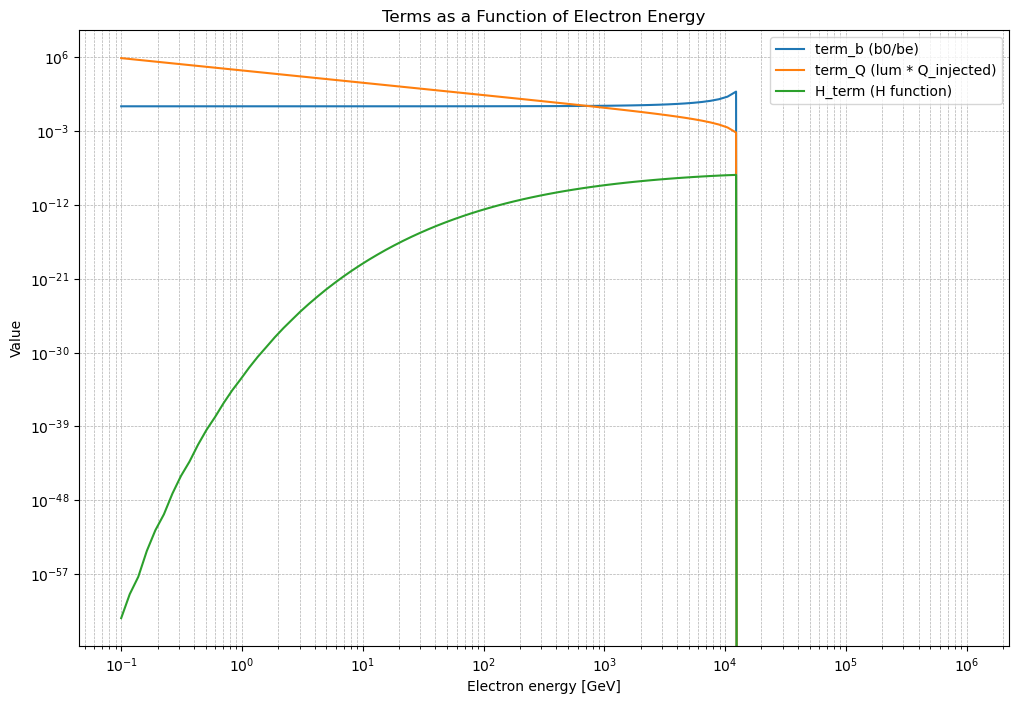

In [36]:
# Defining t
t = (10e3)*conv_yr_sec
r = 10
L0 = newL0


# Generate plots for each term of the result
# Define a range of energies
Ee_range = np.logspace(-1, 6, 100)  # From 0.1 GeV to 1e6 GeV

# Initialize lists to store results
term_b_values = []
term_Q_values = []
H_term_values = []

def L_mauro(t, L0, tau0 = 12*conv_yr_sec):
        return L0/( (1 + t/tau0)**2)

# Calculate terms for each energy
for Ee in Ee_range:
    tdiff = (110e3)*conv_yr_sec - t
    E0 = E0_val(Ee, tdiff)

    if E0 < 0:
        term_b_values.append(0)
        term_Q_values.append(0)
        H_term_values.append(0)
        continue

    b0 = b_tot(E0)
    be = b_tot(Ee)
    term_b_values.append(b0 / be)

    lum = L_mauro(t, L0)
    term_Q_values.append(lum * Q_injected(E0, Q_0))

    H_term_values.append(H(r, Ee, E0, rs=100))

# Plot each term
plt.figure(figsize=(12, 8))

plt.loglog(Ee_range, term_b_values, label="term_b (b0/be)")
plt.loglog(Ee_range, term_Q_values, label="term_Q (lum * Q_injected)")
plt.loglog(Ee_range, H_term_values, label="H_term (H function)")

plt.xlabel("Electron energy [GeV]")
plt.ylabel("Value")
plt.title("Terms as a Function of Electron Energy")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [24]:
# test case
d_gem = 228 # parsecs
t_gem = d_gem/(c*conv_cm_pc)
full_Ne_mauro(1e1, r = 100, t = t_gem, rs = 1)

1.6474891604875642e-05

In [25]:
Ees = np.logspace(np.log10(0.1), np.log10(1e6), 20)

Nes = []

for i in range(20):
    Nes.append(full_Ne_mauro(Ees[i], r = 10, t = t_gem, rs = 1))

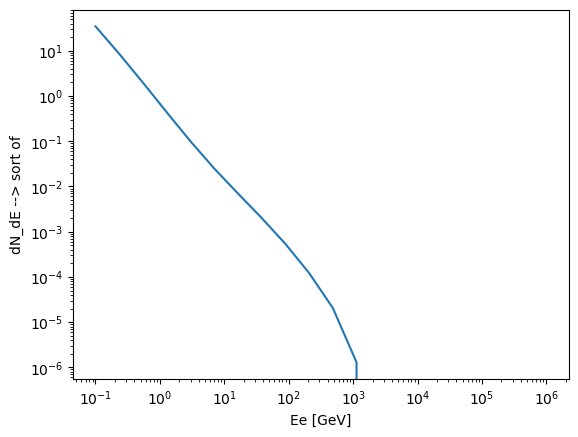

In [26]:
plt.loglog(Ees, Nes)
plt.xlabel("Ee [GeV]")
plt.ylabel("dN_dE --> sort of")
plt.show()

## Integrating over space

In [27]:
def dN_dEe_r(Ee, t):
    '''
    Calculates the differential number density at a given time for
    all of space.

    - perams - 
    t: time to integrate to
    Ee: electron energy 
    r: position in galactic coordinates
    rs: position of source in galactic coordinates

    - returns - 
    differential number density at a given time
    '''
    r_min = 0
    r_max = 100
    rs = np.linspace(r_min, r_max, 10)
    
    def dN_integrand(r, args):
        return full_Ne_mauro(args[0], r, args[1], args[2])*4*np.pi*r**2

    result, error = quad(dN_integrand, r_min, r_max, args = [Ee, t, 0], points = rs, limit = 50)
                       # epsabs=1e-12, epsrel=1e-10, 
    return result



In [28]:
def burst_tot_dN_dE(t):
    n_points = 100
    Ees = np.logspace(np.log10(0.1), np.log10(1e6), n_points)
    
    dNs = []
    for i in range(n_points):
        dNs.append(dN_dEe_r(Ees[i], t,))
        #print(f"appended number {i}")
    
    return dNs, Ees

burst_dNs, Ees = burst_tot_dN_dE(t = 1e11)

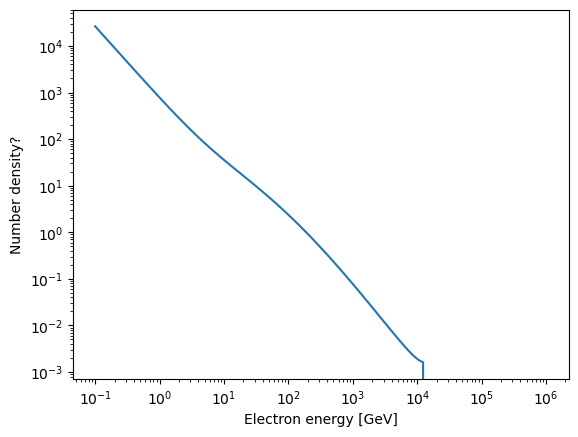

In [29]:
plt.loglog(Ees, burst_dNs)
plt.xlabel("Electron energy [GeV]")
plt.ylabel("Number density?")
plt.show()

## Integrating over time

In [30]:
def dN_dEe_t(t, Ee, r, rs):
    '''
    Calculates the differential number density at a given point
    in space.

    - perams - 
    t: time to integrate to
    Ee: electron energy 
    r: position in galactic coordinates
    rs: position of source in galactic coordinates

    - returns - 
    differential number density at a given point
    '''
    t_min = 0
    t_max = t
    ts = np.linspace(t_min, t_max, 5)
    
    def dN_integrand(t, args):
        return full_Ne_mauro(args[0], args[1], t, args[2])

    result, error = quad(dN_integrand, t_min, t_max, args = [Ee, r, rs], points = ts, 
                        epsabs=1e-12, epsrel=1e-10, limit = 100)

    return result


dN_dEe_t(t_gem, 1e2, r = 10, rs = 1)

650796349.1381509

In [31]:
def cont_dN_dE(t, r, rs):
    n_points = 30
    Ees = np.logspace(np.log10(0.1), np.log10(1e6), n_points)
    
    dNs = []
    for i in range(n_points):
        dNs.append(dN_dEe_t(t, Ees[i], r, rs)) 
    
    return dNs, Ees

dN_dEs, Ees = cont_dN_dE(t = t_gem, r = 10, rs = 1)

/var/folders/wl/gwbb_1zs7579vsxsrtl309740000gn/T/ipykernel_35832/2164326345.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(dN_integrand, t_min, t_max, args = [Ee, r, rs], points = ts,


In [32]:
Ees = np.logspace(np.log10(0.1), np.log10(1e6), 30)

dN_dEe_t(t_gem, Ees[17], r = 10, rs = 1)

/var/folders/wl/gwbb_1zs7579vsxsrtl309740000gn/T/ipykernel_35832/2164326345.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(dN_integrand, t_min, t_max, args = [Ee, r, rs], points = ts,


726593.0398894598

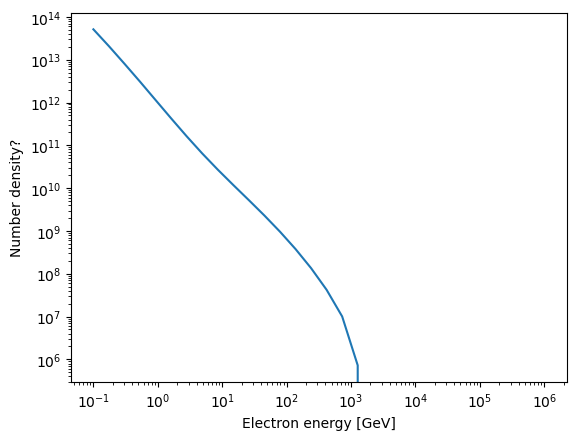

In [33]:
plt.loglog(Ees, dN_dEs)
plt.xlabel("Electron energy [GeV]")
plt.ylabel("Number density?")
plt.show()

# Ba-bal ball ball

In [34]:
def full_dN_dEe(Ee, t_age):
    '''
    Full dN_dE over time and spaaaace.

    - perams - 
    Ee: electron energy [GeV]
    t_age: age of the pulsar
    
    - returns - 
    total N of the pulsar as at a given Ee
    '''
    t_min = 0
    t_max = t_age
    ts = np.linspace(t_min, t_max, 10)

    def r_integrand(t, args):
        return dN_dEe_r(args[0], t)
    

    result, error = quad(r_integrand, t_min, t_max, args = [Ee], points = ts, limit = 50)

    return result

In [35]:
t_age = (110e3)*conv_yr_sec # for monogem
print(full_dN_dEe(10, t_age))

print(full_dN_dEe(1e3, t_age))

978523120360857.6
2033827565349.504


In [36]:
def full_dN_dEe_spec(t_age):
    n_points = 20
    Ees = np.logspace(np.log10(0.1), np.log10(1e6), n_points)
    
    dNs = []
    for i in range(n_points):
        dNs.append(full_dN_dEe(Ees[i], t_age))
    
    return dNs, Ees

# dN_dEs, Ees = full_dN_dEe_spec(t_age)

In [37]:
# import json

# with open('dN_dEes.json', 'w') as f:
#     json.dump(dN_dEs, f)


In [38]:
# Ees_list = Ees.tolist()

# with open('Ees.json', 'w') as f:
#     json.dump(Ees_list, f)

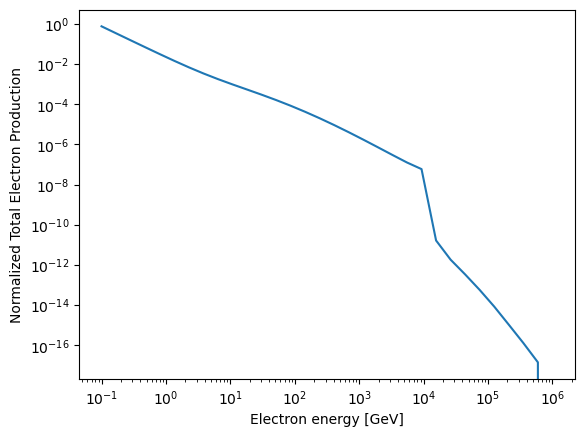

In [44]:
# TO OPEN JSON

# with open('dN_dEes.json', 'r') as f:
#     loaded_dN_dEe = json.load(f)

# Ees = np.logspace(np.log10(0.1), np.log10(1e6), 20).tolist()

# plt.loglog(Ees, loaded_dN_dEe)
# plt.xlabel("Electron energy [GeV]")
# plt.ylabel("Total electron count?")
# plt.show()

# Ees = np.logspace(np.log10(0.1), np.log10(1e6), 20)

Ees = [1.00000000e-01, 1.68192432e-01, 2.82886943e-01, 4.75794431e-01,
    8.00250228e-01, 1.34596032e+00, 2.26380341e+00, 3.80754602e+00,
    6.40400427e+00, 1.07710506e+01, 1.81160919e+01, 3.04698957e+01,
    5.12480588e+01, 8.61953566e+01, 1.44974067e+02, 2.43835410e+02,
    4.10112707e+02, 6.89778538e+02, 1.16015530e+03, 1.95129342e+03,
    3.28192787e+03, 5.51995432e+03, 9.28414545e+03, 1.56152301e+04,
    2.62636353e+04, 4.41734470e+04, 7.42963951e+04, 1.24960914e+05,
    2.10174801e+05, 3.53498111e+05, 5.94557071e+05, 1.00000000e+06]
Ns = [42986249.33563321, 19314940.550122917, 8681821.583751703, 3921233.43623783, 1783398.269782106, 824202.2648724382, 391868.55412676587, 194596.14330845428, 101549.14199104476, 55279.878376002125, 30743.0145321653, 17029.093912415407, 9202.073181977878, 4787.787625738846, 2384.751838950819, 1136.5019919404317, 519.6581758974721, 229.0384968358647, 97.9142928860984, 40.957287750108, 16.977060371894567, 7.153230922193994, 3.3540834566589997, 0.0009385171832532289, 0.00010380957892516929, 1.9122430100293546e-05, 3.231152576521166e-06, 4.785922847169522e-07, 6.014113471742749e-08, 7.37952753086662e-09, 8.073416593628567e-10, 0.0]

Ns /= np.trapz(Ns)

plt.loglog(Ees, Ns)
plt.xlabel("Electron energy [GeV]")
plt.ylabel("Normalized Total Electron Production")
plt.show()

# Esquared_dN_dEe = []

# for i in range(20):
#     weight = 9.3e39
#     E_sq = Ees[i]**2
#     Esquared_dN_dEe.append(loaded_dN_dEe[i]*E_sq*weight)

# plt.loglog(Ees, Esquared_dN_dEe)
# plt.xlabel("Electron energy [GeV]")
# plt.ylabel("E^2 Counts?")
# plt.show()